## 1. <font color = red> Install and Import the Required Libraries

## Imports

In [ ]:
# Import all the required Libraries

import time
import pdfplumber
from PyPDF2 import PdfReader, PdfWriter
from pathlib import Path
import pandas as pd
from operator import itemgetter
from IPython.display import display, Markdown
import json
import os
from dotenv import load_dotenv
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnablePassthrough, RunnableBranch
from langchain_core.messages import AIMessage
from operator import itemgetter
from langchain_chroma import Chroma
from langchain_mistralai import MistralAIEmbeddings
from langchain_mistralai import ChatMistralAI
from uuid import uuid4
from langchain_community.retrievers import BM25Retriever
from sentence_transformers import CrossEncoder, util
from langchain.agents.middleware import ModelFallbackMiddleware
from dotenv import load_dotenv

In [2]:
load_dotenv()

MISTRAL_GENERATOR = os.getenv("MISTRAL_GENERATOR") #mistral medium
MISTRAL_QA_GENERATOR = os.getenv("MISTRAL_QA_GENERATOR") #mistral small

MISTRAL_BACKUP_1 = os.getenv("MISTRAL_BACKUP_1")
MISTRAL_BACKUP_2 = os.getenv("MISTRAL_BACKUP_2")
MISTRAL_MODERATION = os.getenv("MISTRAL_MODERATION")

## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using pdfplumber to read and process the PDF files.

#### <font color = red>  2.1 Reading the PDF file and exploring it through pdfplumber

#### <font color = red>  2.2 Process the PDF file

*   We will delete the first 8 and last 3 pages of the pdf file as it contains table of contents which is not important for our use case.
*  Also I removed the footers, because it can cause issues while processing the text for chunking





In [3]:

def crop_pdf_footer(input_pdf: str, output_pdf: str, footer_fraction: float = 0.15):
    """
    Crops the footer from each page of the PDF and saves the cropped PDF.

    :param input_pdf: Path to the input PDF file.
    :param output_pdf: Path to the output cropped PDF file.
    :param footer_fraction: Fraction of the page height to be cropped from the bottom.
    """
    # Read the input PDF
    reader = PdfReader(input_pdf)
    writer = PdfWriter()

    for page in reader.pages[8:-3]:
        # Get the dimensions of the current page
        media_box = page.mediabox
        width = float(media_box.width)
        height = float(media_box.height)

        # Calculate the new dimensions after cropping
        new_lower_bound = float(media_box.lower_left[1]) + (footer_fraction * height)

        # Update the mediabox to crop the footer
        page.mediabox.lower_left = (media_box.lower_left[0], new_lower_bound)
        page.mediabox.lower_right = (media_box.lower_right[0], new_lower_bound)

        # Add the cropped page to the writer
        writer.add_page(page)

    # Write the output PDF
    with open(output_pdf, "wb") as output_file:
        writer.write(output_file)
    print(f"Cropped PDF saved to {output_pdf}")


# Example usage
input_pdf_path = os.getenv("POLICY_PDF_PATH")
output_pdf_path = os.getenv("POLICY_PDF_PATH_OUTPUT")
crop_pdf_footer(input_pdf_path, output_pdf_path, footer_fraction=0.12)


Cropped PDF saved to C:/Users/paymo/Downloads/MrHelpMateAI_Harshad/data/Principal-Sample-Life-Insurance-Policy-Cleaned.pdf


#### <font color = red> 2.3 Extracting text from PDFs and chunking the whole file

Let's now read the whole documents, extract text from them using appropriate preprocessing, and store it in a dataframe


In [4]:
chunk_output_path = os.getenv("OUTPUT_CHUNK_PATH")

In [5]:

def chunk_pdf_with_metadata(pdf_path, chunk_output_path=chunk_output_path):
    """
    Reads a PDF, extracts chunks (Articles or paragraphs), and attaches metadata.
    If Articles are not present we will chunk the text through paragraphs else through articles.
    Args:
        pdf_path (str): Path to the input PDF file.

    Metadata: will contain the page number, PART header, section header and article heading

    Returns:
        list[dict]: List of chunks with metadata.
    """
    chunks = []
    current_part = 0
    current_section = 0
    current_article = 0
    is_content = False

    with pdfplumber.open(pdf_path) as pdf:
        for page_number, page in enumerate(pdf.pages, start=1):
            text = page.extract_text()
            if not text:
                continue

            lines = text.splitlines()
            current_chunk = []

            for line in lines:
                # Detect Parts
                if line.strip().replace(' ','').startswith("PART") and ('section' not in line.strip().lower() and 'article' not in line.strip().lower()):
                    current_part = line.strip()
                    continue

                # Detect Sections
                if line.strip().replace(' ','').startswith("Section"):
                    current_section = line.strip()
                    continue

                # Detect Articles
                if line.strip().replace(' ','').startswith("Article"):
                    # Save the previous chunk if it exists
                    if current_chunk:
                        chunks.append({
                            "Text": " ".join(current_chunk).strip(),
                            "Metadata": {
                              "PART_DETAILS": current_part,
                              "SECTION_DETAILS": current_section,
                              "ARTICLE_DETAILS": current_article,
                              "PAGE_NO": page_number,
                          }
                        })
                        current_chunk = []

                    # Update current article
                    current_article = line.strip()
                    continue

                # Add content to the current chunk
                current_chunk.append(line)

            # Save any remaining content on the page
            if current_chunk:
                chunks.append({
                    "Text": " ".join(current_chunk).strip(),
                    "Metadata": {
                        "PART_DETAILS": current_part,
                        "SECTION_DETAILS": current_section,
                        "ARTICLE_DETAILS": current_article,
                        "PAGE_NO": page_number,
                    }
                })
                current_chunk = []

    # Open a file in write mode and dump the data
    with open(chunk_output_path, 'w') as json_file:
        json.dump(chunks, json_file, indent = 4)
    return chunks


In [6]:
extracted_text = chunk_pdf_with_metadata(output_pdf_path, chunk_output_path=chunk_output_path)
extracted_text_df = pd.DataFrame(extracted_text, columns=['Text', 'Metadata'])
extracted_text_df[:8]

,Text,Metadata
0,When used in this Group Policy the terms liste...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC..."
1,T he legally recognized union of two eligible ...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC..."
2,(2) has been placed with the Member or spouse ...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC..."
3,An institution that is licensed as a Hospital ...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC..."
4,a . A licensed Doctor of Medicine (M.D.) or Os...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC..."
5,c . end stage renal failure; or d. acquired im...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC..."
6,A record which is on or transmitted by paper o...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC..."
7,"This Group Policy, the current Certificate, th...",{'PART_DETAILS': 'PART II - POLICY ADMINISTRAT...


In [7]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

extracted_text_df['Text_Length'] = extracted_text_df['Text'].apply(lambda x: len(x.split(' ')))

In [8]:
#Combine Chunks by Sections
#If sectiion is not available combine with part

combined_chunks = {}
for index, row in extracted_text_df.iterrows():
    meta_dic = dict(row['Metadata'])
    part = meta_dic['PART_DETAILS']
    section = meta_dic['SECTION_DETAILS']
    article = meta_dic['ARTICLE_DETAILS']
    combined_chunks.setdefault(f"Part: {part}, Section: {section}, Article: {article}", []).append(row['Text'])

for key, value in combined_chunks.items():
    combined_chunks[key] = ''.join(combined_chunks[key])


In [9]:
# Retain only the rows with a text length of at least 20

extracted_text_df_cleaned = extracted_text_df.loc[extracted_text_df['Text_Length'] >= 20]
extracted_text_df_cleaned

,Text,Metadata,Text_Length
0,When used in this Group Policy the terms liste...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC...",382
1,T he legally recognized union of two eligible ...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC...",251
2,(2) has been placed with the Member or spouse ...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC...",299
3,An institution that is licensed as a Hospital ...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC...",352
4,a . A licensed Doctor of Medicine (M.D.) or Os...,"{'PART_DETAILS': 'P ART I - DEFINITIONS', 'SEC...",260
...,...,...,...
98,A Member may name or later change a named bene...,"{'PART_DETAILS': 'PART IV - BENEFITS', 'SECTIO...",81
99,Written notice must be sent to The Principal b...,"{'PART_DETAILS': 'PART IV - BENEFITS', 'SECTIO...",70
100,"The Principal, when it receives notice of clai...","{'PART_DETAILS': 'PART IV - BENEFITS', 'SECTIO...",70
101,Written proof of loss must be sent to The Prin...,"{'PART_DETAILS': 'PART IV - BENEFITS', 'SECTIO...",104


In [10]:
extracted_text_df_cleaned['Text_Length'].describe()

count     99.000000
mean     149.595960
std      114.175118
min       20.000000
25%       64.500000
50%      104.000000
75%      217.500000
max      455.000000
Name: Text_Length, dtype: float64

This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 455.
1. The way insurance documents is structured, we need to separate each paragraph or an article as a chunk as chunks.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer that's why we removed the chunks having less than 20 words

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [11]:
# Set the API key
load_dotenv()
os.environ['MISTRAL_API_KEY'] = os.getenv("MISTRAL_API")
# MISTRALAI_API_KEY = os.getenv("MISTRAL_API")
embeddings = MistralAIEmbeddings(model="mistral-embed")

In [12]:
# # #Connect to chroma cloud
# # #This is for latter use for final processing only
# # load_dotenv()

# # vector_store = Chroma(
# #     collection_name="collection_insurance",
# #     embedding_function=embeddings,
# #     chroma_cloud_api_key=os.getenv("CHROMA_API_KEY"),
# #     tenant=os.getenv("CHROMA_TENANT"),
# #     database=os.getenv("CHROMA_DATABASE"),
# # )

# #For now we will use local storage

# load_dotenv()

insurance_collection = Chroma(
    collection_name="collection_insurance",
    embedding_function=embeddings,
    persist_directory=os.getenv("CHROMA_PERSISTENT"),  # Where to save data locally, remove if not necessary
)

In [ ]:
# # Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.


# #Create docs to store as chunk
# docs = [
#     Document(
#         page_content=chunk["Text"],
#         metadata=chunk["Metadata"]
#     )
#     for index, chunk in extracted_text_df_cleaned.iterrows()
# ]

# uuids = [str(uuid4()) for _ in range(len(docs))]
# insurance_collection.add_documents(documents=docs, ids=uuids)

['057904c9-1f9d-4f4d-8b94-13726556bf6f',
 'b46f406f-63ee-4493-8456-a1597ab359cf',
 'c67e04f3-7027-4c0e-bc24-3aa2f069c9cb',
 '7b92d896-9fc8-43e4-9e64-dafbd66eb52e',
 '3975e603-e9c3-40c3-b911-ad71a9b50972',
 'b30e624f-5cde-4ea7-8cd3-e632ecfb6008',
 'f21f18b1-ca10-4c86-90a9-5b419c1be152',
 'f8bb4518-e54f-4759-b37a-708003903ab4',
 '1f92827b-c7fd-4e7e-ad33-cd469ecea9fa',
 '4b8b5037-ed5f-48ad-9ec5-b0540e93a404',
 'f35861c5-2dbf-4a07-ae67-8a0fa76cb3c2',
 'a2e3c2c6-247f-4634-b548-a2bb2a63aaa0',
 '350f2108-fe2d-4e5f-8f8a-5251ad21fb03',
 'dd4b5161-193f-49ce-a7f3-920d43b2b53f',
 'f48dc4c0-a348-461f-8317-5e9411bfffff',
 '1c094e64-ba8b-4d08-a05b-cbcd27942738',
 'af8da315-146e-4d69-a789-fa9b24927db6',
 'edf5f96d-3312-4bfb-9511-3515cd005493',
 'a78e93dc-e20d-44b2-8479-61f47135ba3c',
 '23a68fc9-9f26-48ed-9b65-5a3b300b28eb',
 '4512a578-a3c1-44c4-ab05-56801039e6b1',
 '8c33d136-3ae6-4c4a-9df9-63c8d1043eb1',
 '1f2a6506-fd4b-476c-820d-060a30365bc8',
 'af781f59-6edf-4e0e-98b8-fc091004f7a2',
 '7174861b-4ece-

In [ ]:
# # Let's take a look at the first few entries in the collection
# insurance_collection.get(
#     ids = uuids[:3],
#     include = ['embeddings', 'documents', 'metadatas']
# )

{'ids': ['057904c9-1f9d-4f4d-8b94-13726556bf6f',
  'b46f406f-63ee-4493-8456-a1597ab359cf',
  'c67e04f3-7027-4c0e-bc24-3aa2f069c9cb'],
 'embeddings': array([[-0.04122925,  0.02424622,  0.02407837, ..., -0.01078033,
          0.00731659, -0.00305176],
        [-0.05102539, -0.01514435,  0.04000854, ...,  0.0191803 ,
          0.02679443,  0.00254631],
        [-0.05578613,  0.01328278,  0.02772522, ...,  0.0056839 ,
          0.02507019, -0.01041412]], shape=(3, 1024)),
 'documents': ["When used in this Group Policy the terms listed below will mean: Active Work; Actively at Work A Member will be considered Actively at Work if he or she is able and available for active performance of all of his or her regular duties. Short term absence because of a regularly scheduled day off, holiday, vacation day, jury duty, funeral leave, or personal time off is considered Active Work provided the Member is able and available for active performance of all of his or her regular duties and was working th

## Retriever

In [187]:
chroma_retriever = insurance_collection.as_retriever(
    search_type = "similarity_score_threshold",
    search_kwargs = {"k":10, "score_threshold":0.55}  #Higher score -> hihger similarity
)

## LLM

In [ ]:
os.environ['MISTRAL_API_KEY'] = os.getenv("MISTRAL_API")
llm_gen = ChatMistralAI(
    model= MISTRAL_GENERATOR,
    temperature=0,
    max_retries=2
    ).with_fallbacks(
        [
            ChatMistralAI(model = MISTRAL_BACKUP_1, temperature = 0, max_retries=2),
            ChatMistralAI(model = MISTRAL_BACKUP_2, temperature = 0, max_retries=2)
        ]
    )

## Formatter

In [152]:
def format_docs_with_metadata(results):
    results_dict = {}
    #Keeping only the relevant results to the query
    for doc in results:
        results_dict.setdefault('Documents', []).append(doc.page_content)
        results_dict.setdefault('ID', []).append(doc.id)
        results_dict.setdefault('Metadatas', []).append(doc.metadata)

    results_df = pd.DataFrame(results_dict)
    return results_df


## Cross Encoder Re-Ranking

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

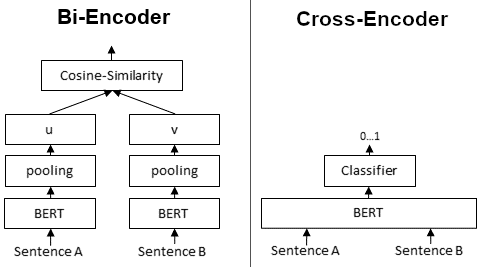

<br>

In [ ]:
#These are small neural networks designed for reranking task.

# Load cross encoder once
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

def rerank_documents(query, results_df):
    """Re-rank retrieved docs using CrossEncoder."""
    
    # Get query from context (will be passed via RunnableParallel)
    # This is a simplification; see full example below for proper context flow
    cross_inputs = [[query, response] for response in results_df['Documents']]
    cross_rerank_scores = cross_encoder.predict(cross_inputs)
    
    # Sort by score descending
    results_df['Reranked_scores'] = cross_rerank_scores
    
    results_df = results_df.sort_values(by='Reranked_scores', ascending=False)
    top_3_results = results_df[:3]

    #Return context in string
    context = ""
    for i, row in results_df.iterrows():
        context += f"\n[DOC {i}]\n{row['Documents']}\nMETA: {row['Metadatas']}\n"
    

    return [top_3_results[['Documents','Metadatas']], context]


## Set Template

In [172]:
SYSTEM_PROMPT = """You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in '{context}'. These search results are essentially one page of an insurance document that may be relevant to the user query.
Use the documents in '{context}' to answer the query '{query}'. Understand and frame an informative answer, and also return the relevant PART, Section, Article, and Page as citations present in the form of dictionary in '{metadatas}'

Follow the guidelines below when performing the task:
1. Try to provide relevant/accurate numbers if available and if no {context} is relevant to the {query} answer yourself.
2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
3. Use the Metadatas column in the dataframe to retrieve and provide citations
  The Metdata dictionary is predent inside "{metadatas}":
  Read it and provide all the citations which you think can be helpful for user to refer, you are free to provide citations from this metadata
  - Article: Please refer to '{metadatas}' and provide values present against 'article'.
  - Page Number: Please refer to '{metadatas}' and provide values present against 'page'.
  - Part: Please refer to '{metadatas}' and provide values present against 'part'.
  - Section: Please refer to '{metadatas}' and provide values present against 'section'
5. Provide citations against the same text which you referred from the top_3_RAG table.
6. You are a customer-facing assistant, so do not provide any information on internal workings; just answer the query directly.
7. Please carefully look for the citation inside the "Metadatas"; don't miss it.

The generated response should answer the query directly, addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
Do not paraphrase unless necessary.
"""

## Small - Talk Router

In [173]:
SMALL_TALK_PATTERNS = [

    # How-are-you / what’s up
    r"how (are|r) (you|u)\b",
    r"how's it going\b",
    r"how are you doing\b",
    r"what('?s| is) up\b",
    r"what('?s| is) going on\b",
    r"how is life\b",

    # Bot identity / capability
    r"who are you\b",
    r"what can you do\b",
    r"how can you help\b",
    r"what are you\b",
    r"are you (a )?bot\b",
    r"are you human\b",

    # Jokes / fun
    r"tell me a joke\b",
    r"say something funny\b",
    r"make me laugh\b",

]

import re

def is_small_talk(q: str):
    q = q.lower().strip()
    return any(re.search(p, q) for p in SMALL_TALK_PATTERNS)

small_talk = RunnableLambda(
    lambda x: AIMessage(content="Hi! I can help with insurance policy questions :)")
)


## Moderation Check

In [174]:
mod_llm = ChatMistralAI(model="open-mistral-nemo")

mod_prompt = ChatPromptTemplate.from_template(
"""
Rate if this is SAFE or BLOCK:

Query: {input}

BLOCK ONLY if: VIOLENCE, HATE, HARASSMENT, SEXUAL, ILLEGAL, SELF-HARM.
Respond ONLY: 'SAFE' OR 'BLOCK' based on your evaluation
"""
)

moderator = (
    mod_prompt
    | mod_llm
    | RunnableLambda(lambda x: "SAFE" in x.content)
)

block_chain = RunnableLambda(
    lambda x: AIMessage(content="I cannot answer harmful or inappropriate questions.")
)


In [175]:
chroma = Chroma(persist_directory=os.getenv("CHROMA_PERSISTENT"), embedding_function=embeddings)
all_docs = chroma.get()  # Extract ALL docs (or sample)

## Final Chain

In [204]:
prompt = ChatPromptTemplate.from_messages([
    ("system", SYSTEM_PROMPT),
    ("human", "{query}")
])

fallback = RunnableLambda(
    lambda x: AIMessage(content="Sorry! This information is unavailable in the knowledge base.")
)


normal = (
    RunnableLambda(lambda x :{
            "query": x["query"],
            "bm-25-retrieved": BM25Retriever.from_documents(x['retrieved'], k=len(x['retrieved'])).invoke(x['query'])
        })
        | RunnableLambda(lambda x: {
            "query": x["query"],
            "results_df": format_docs_with_metadata(x["bm-25-retrieved"])
        })
        |
        RunnableLambda(lambda x: {
        "query": x["query"],
        "top_docs_and_context": rerank_documents(x["query"], x["results_df"])
        })
        | RunnableLambda (lambda x: {
            "query": lambda x: x["query"],
            "context" : x["top_docs_and_context"][1],
            "metadatas" : x["top_docs_and_context"][0]["Metadatas"]
        })
        | prompt 
        | llm_gen
)


chain = RunnableBranch(
    # moderation first
    (lambda x: not moderator.invoke({"input": x["query"]}), block_chain),

    # small-talk
    (lambda x: is_small_talk(x["query"]), small_talk),

    # RAG pipeline
    (
        RunnableParallel({
            "query": lambda x: x["query"],
            "retrieved": lambda x: chroma_retriever.invoke(x["query"]),
        })
        | RunnableBranch(
            # if results_df is empty → fallback
            (lambda x: not x["retrieved"], fallback),
            # otherwise → continue normal path
            normal,
        )
    ),
)


In [205]:
#Input you query here
query = input()
response = chain.invoke({"query": query})
display(Markdown(response.content))

No relevant docs were retrieved using the relevance score threshold 0.55


Sorry! This information is unavailable in the knowledge base.